# Machine learning notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from meteostat import Point, Hourly,Stations
from datetime import datetime
import seaborn as sns




In [2]:
data=pd.read_csv('PV_raw_data.csv')
data['Energy Generated (MWh)']=data['AC System Output (W)']*0.000001
data.drop(columns=['AC System Output (W)','DC Array Output (W)','Albedo'],  inplace=True)

In [3]:
#Transform the DF into datetime
data['year'] = 2023


# Create a datetime column
data['datetime'] = pd.to_datetime(data[['year', 'Month', 'Day', 'Hour']])


# Set datetime as the index
data.set_index('datetime', inplace=True)


# Drop the dummy year column as it is no longer needed
data.drop(columns=['Day','year'], inplace=True)



In [4]:

stations = Stations()
stations = stations.region('GR')
station = stations.fetch(1)

start = datetime(2023,1,1)
end = datetime(2023,12,31,23)

weather_data=Hourly(station,start,end)
weather_data = weather_data.fetch()
weather_data=weather_data.dropna(axis=1,how='all')
weather_data.drop(columns=['wspd'],inplace=True)
print(weather_data)

                     temp  dwpt   rhum  prcp   wdir    pres  coco
time                                                             
2023-01-01 00:00:00   2.1   1.8   98.0   0.0   59.0  1032.3   1.0
2023-01-01 01:00:00   2.1   2.1  100.0   0.0  124.0  1032.8   1.0
2023-01-01 02:00:00   1.8   1.8  100.0   0.0   72.0  1032.8   1.0
2023-01-01 03:00:00   0.4   0.3   99.0   0.0    0.0  1032.3   1.0
2023-01-01 04:00:00   0.2   0.2  100.0   0.0  184.0  1032.6   1.0
...                   ...   ...    ...   ...    ...     ...   ...
2023-12-31 19:00:00   6.4   5.8   96.0   0.0  147.0  1019.9   3.0
2023-12-31 20:00:00   5.9   5.5   97.0   0.0  124.0  1019.9   4.0
2023-12-31 21:00:00   7.1   5.7   91.0   0.0   77.0  1019.9   4.0
2023-12-31 22:00:00   6.5   5.4   93.0   0.0  170.0  1019.8   4.0
2023-12-31 23:00:00   5.9   5.3   96.0   0.0  198.0  1019.6   4.0

[8760 rows x 7 columns]


In [5]:
data.columns

Index(['Month', 'Hour', 'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Wind Speed (m/s)',
       'Plane of Array Irradiance (W/m2)', 'Cell Temperature (C)',
       'Energy Generated (MWh)'],
      dtype='object')

In [6]:
data_combined=pd.concat([data ,weather_data],axis=1)


Correlation with 'Energy Generated (MWh)':
Month                              -0.025087
Hour                                0.040129
Beam Irradiance (W/m2)              0.949383
Diffuse Irradiance (W/m2)           0.750786
Ambient Temperature (C)             0.474802
Wind Speed (m/s)                    0.264585
Plane of Array Irradiance (W/m2)    0.998823
Cell Temperature (C)                0.800871
Energy Generated (MWh)              1.000000
temp                                0.575426
dwpt                                0.153282
rhum                               -0.606818
prcp                                0.129696
wdir                                0.095542
pres                               -0.132305
coco                                0.049151
Name: Energy Generated (MWh), dtype: float64


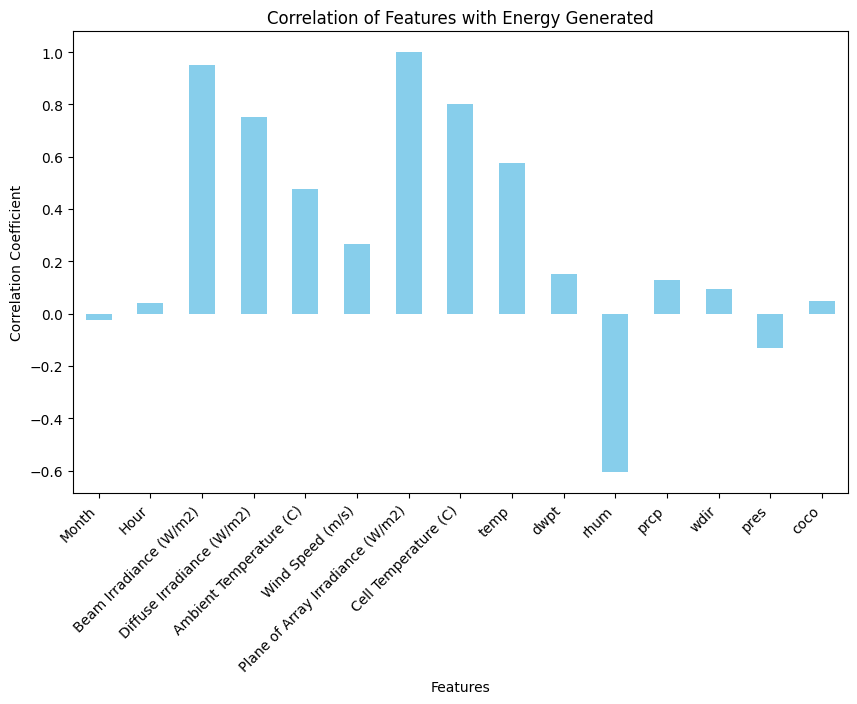

In [7]:
import pandas as pd



# Select relevant features and target variable
features = ['Month', 'Hour', 'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
            'Ambient Temperature (C)', 'Wind Speed (m/s)',
            'Plane of Array Irradiance (W/m2)', 'Cell Temperature (C)', 'temp', 
            'dwpt', 'rhum', 'prcp', 'coco']
target = 'Energy Generated (MWh)'

# Include the target variable in the data subset


# Calculate the correlation matrix
correlation_matrix = data_combined.corr()

# Extract correlations with the target variable
correlations_with_target = correlation_matrix[target]

# Display the correlations
print("Correlation with 'Energy Generated (MWh)':")
print(correlations_with_target)

# Optionally, visualize the correlations with the target variable using a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
correlations_with_target.drop(target).plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Energy Generated')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()


Variance Inflation Factor (VIF) for each feature:
                             Feature        VIF
0                              Month   5.492528
1                               Hour   4.047994
2             Beam Irradiance (W/m2)  45.216657
3          Diffuse Irradiance (W/m2)  11.435067
4            Ambient Temperature (C)  67.938288
5                   Wind Speed (m/s)   3.274730
6   Plane of Array Irradiance (W/m2)  83.582557
7               Cell Temperature (C)  64.566889
8                               temp  39.547006
9                               dwpt   9.699361
10                              rhum   9.396871
11                              prcp   1.185110
12                              coco   3.677564


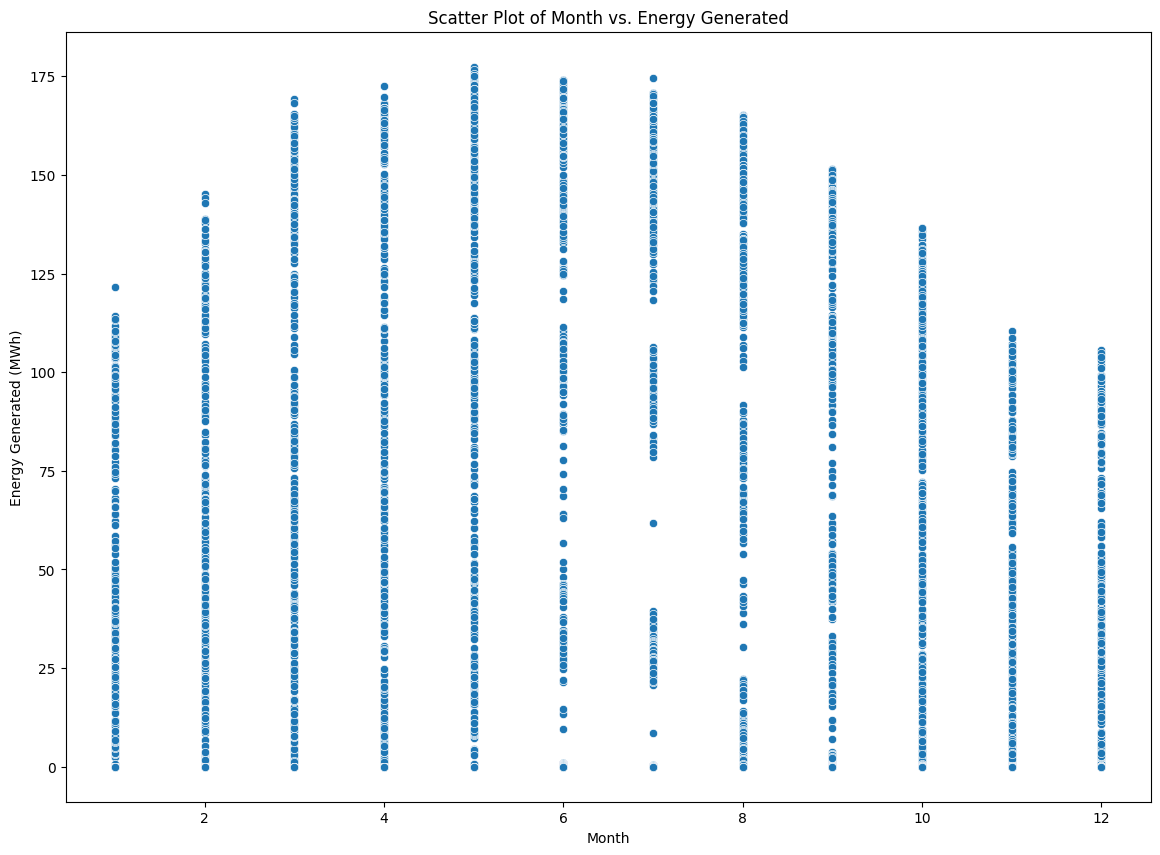

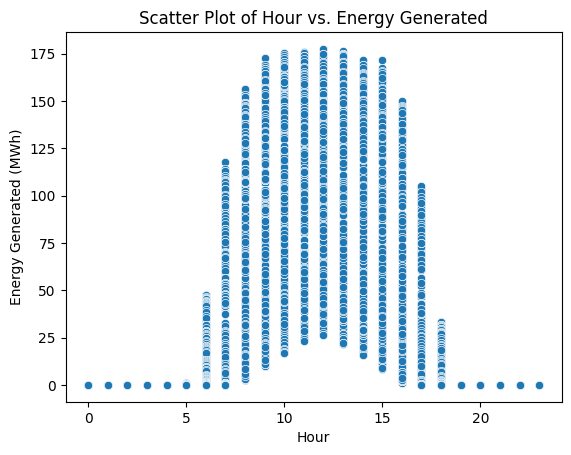

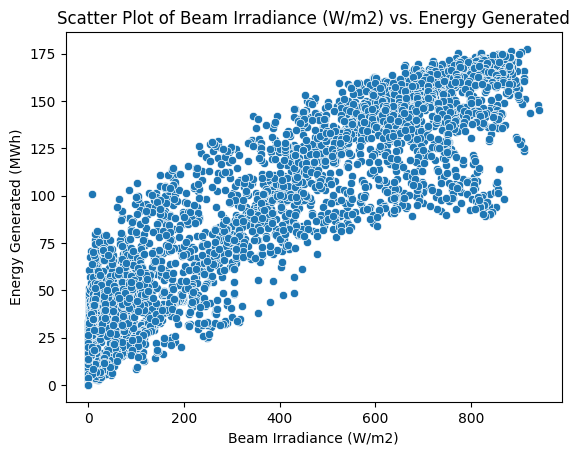

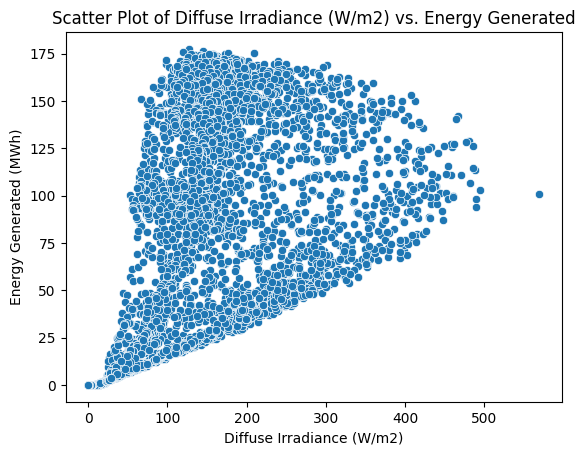

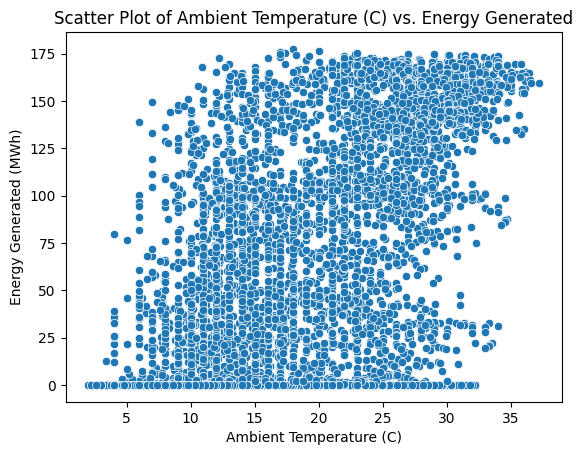

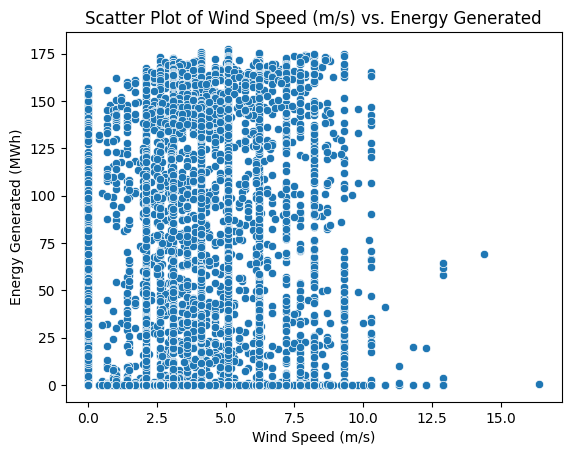

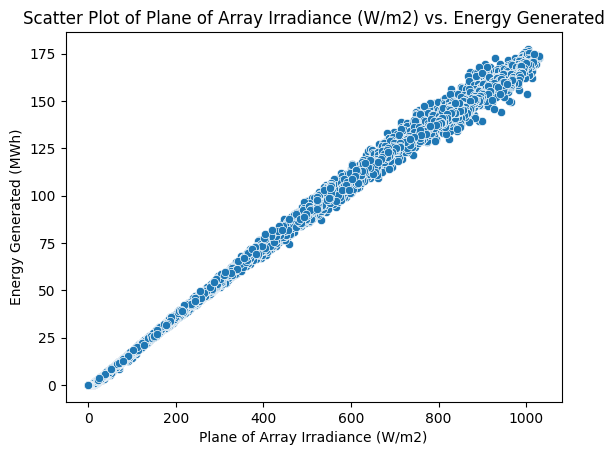

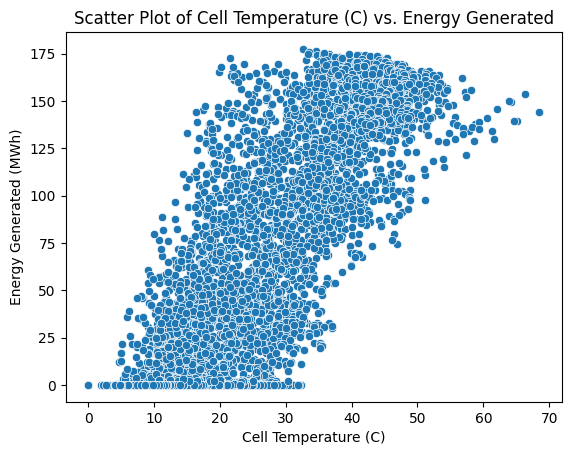

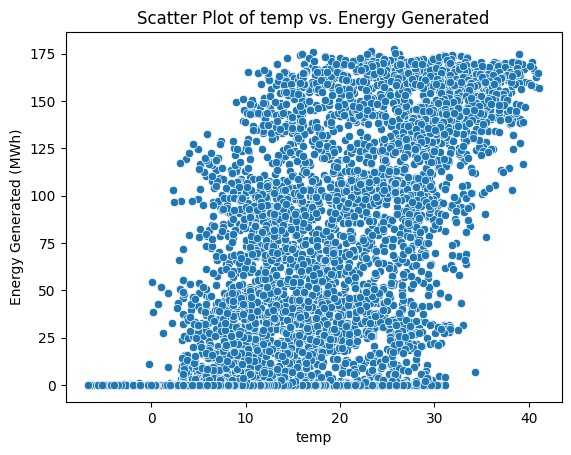

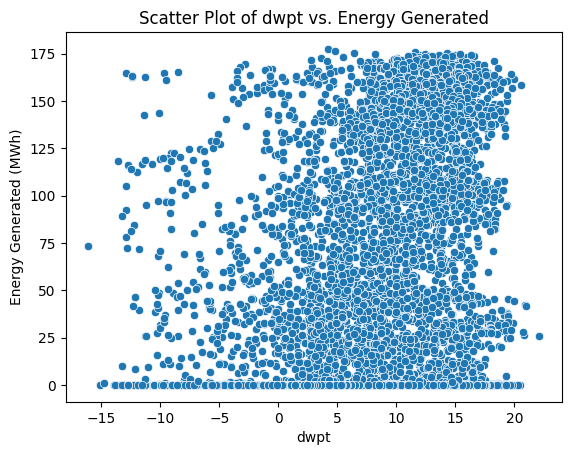

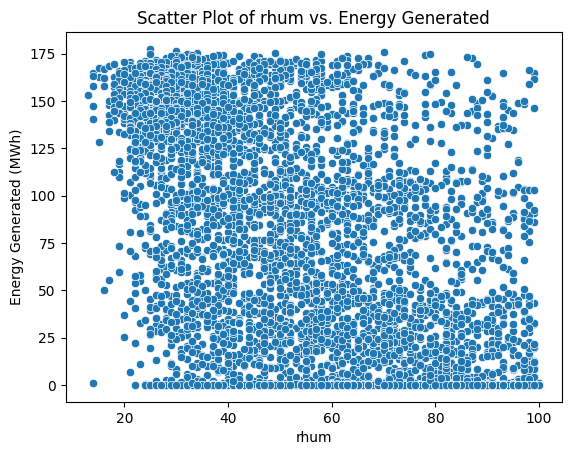

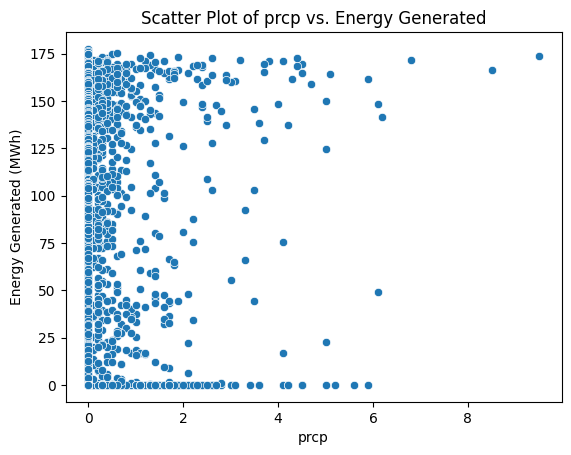

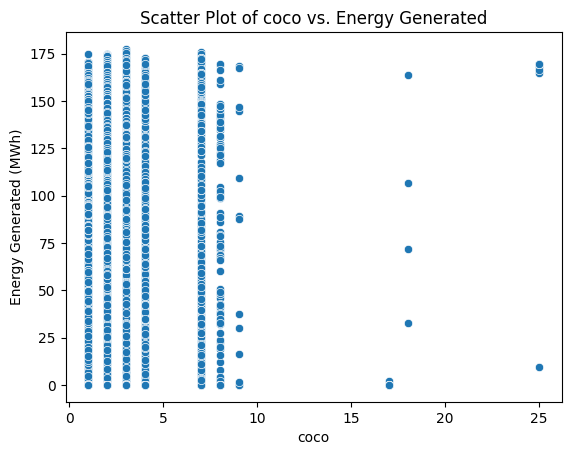

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Add a constant column for VIF calculation
X = data_combined[features]
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy variables if any

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF) for each feature:")
print(vif_data)

# Plot scatter plots to check relationships
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
for feature in features:
    sns.scatterplot(data=data_combined, x=feature, y='Energy Generated (MWh)')
    plt.title(f'Scatter Plot of {feature} vs. Energy Generated')
    plt.xlabel(feature)
    plt.ylabel('Energy Generated (MWh)')
    plt.show()


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load your dataset


# Updated list of features and target
features = ['Month', 'Hour', 'temp', 'dwpt', 'rhum', 'prcp', 'coco']
target = 'Energy Generated (MWh)'

X = data_combined[features]
y = data[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [42]:
# Initialize Lasso model
lasso = Lasso(alpha=0.01)  # Adjust alpha as needed

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate performance
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print(f'Lasso Regression MAE: {mae_lasso}')
print(f'Lasso Regression MSE: {mse_lasso}')
print('Lasso Coefficients:', lasso.coef_)


Lasso Regression MAE: 30.919351543488936
Lasso Regression MSE: 1604.6803765512677
Lasso Coefficients: [ -3.92067288  -5.52254297  79.75408872 -47.16514098  16.51324397
   5.46131299  10.90754052]


In [43]:
# Initialize Ridge model
ridge = Ridge(alpha=1.0)  # Adjust alpha as needed

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ridge = ridge.predict(X_test_scaled)

# Evaluate performance
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f'Ridge Regression MAE: {mae_ridge}')
print(f'Ridge Regression MSE: {mse_ridge}')
print('Ridge Coefficients:', ridge.coef_)


Ridge Regression MAE: 30.916330739316805
Ridge Regression MSE: 1604.6782099517275
Ridge Coefficients: [ -3.93589648  -5.52772712  80.01627047 -47.358685    16.70327861
   5.46867232  10.91172685]


In [44]:
from sklearn.linear_model import LassoCV, RidgeCV

# LassoCV for automatic alpha selection
lasso_cv = LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)
lasso_cv.fit(X_train_scaled, y_train)
print('Best Lasso Alpha:', lasso_cv.alpha_)

# RidgeCV for automatic alpha selection
ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge_cv.fit(X_train_scaled, y_train)
print('Best Ridge Alpha:', ridge_cv.alpha_)


Best Lasso Alpha: 0.1
Best Ridge Alpha: 0.1


Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3942.9705 - val_loss: 1210.8994
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1082.8464 - val_loss: 695.0167
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 610.1885 - val_loss: 569.3922
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 573.4935 - val_loss: 550.9073
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 471.3460 - val_loss: 506.0280
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 485.3015 - val_loss: 535.7276
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 461.8182 - val_loss: 448.3802
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 433.0401 - val_loss: 506.7525
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 437.9413 - val_loss: 403.0002
Epoch 10/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 394.6348 - val_loss: 445.7082
Epoch 11/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 407.2736 - val_loss: 44

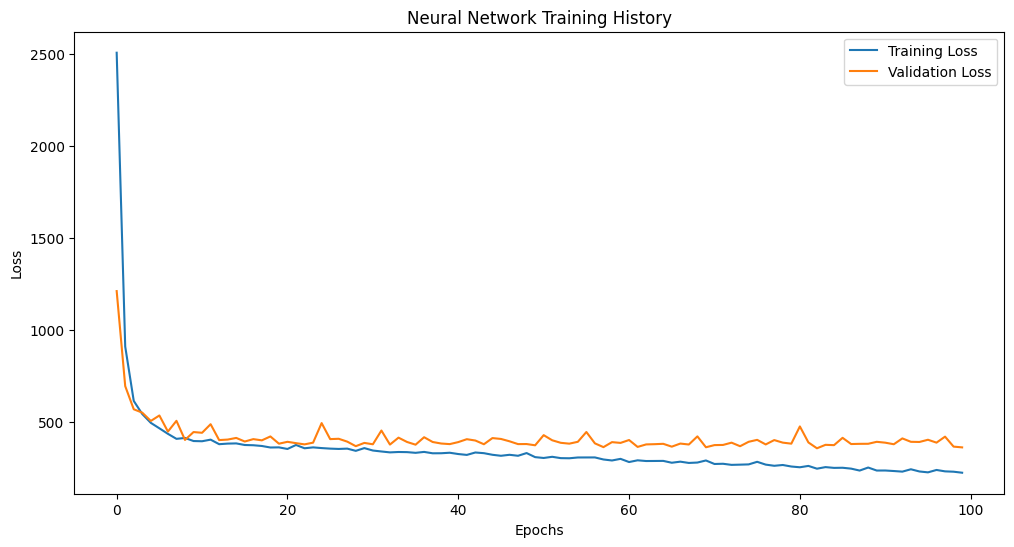

In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.regularizers import L2,L1

# Load and prepare your dataset

# features = ['Month', 'Hour', 'Ambient Temperature (C)', 'Wind Speed (m/s)', 'Cell Temperature (C)', 'temp', 
#             'dwpt', 'rhum', 'prcp', 'coco']
# target = 'Energy Generated (MWh)'

X = data_combined[features]
y = data_combined[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer            
    keras.layers.Dense(200, activation='relu',kernel_regularizer=L2(0.01)),
    keras.layers.Dense(75, activation='relu',kernel_regularizer=L2(0.01)),          # Hidden layer 1    
    keras.layers.Dense(50,activation='relu',kernel_regularizer=L2(0.01)),
    keras.layers.Dense(50,activation='relu',kernel_regularizer=L2(0.01)),
    keras.layers.Dense(50,activation='relu',kernel_regularizer=L2(0.01)),
    keras.layers.Dense(50,activation='relu',kernel_regularizer=L2(0.01)),# Hidden layer 2
    keras.layers.Dense(25,activation='relu',kernel_regularizer=L2(0.01)),
    keras.layers.Dense(1,activation='relu',kernel_regularizer=L2(0.01))             # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.23, 
                    verbose=1)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Neural Network MAE: {mae}')
print(f'Neural Network MSE: {mse}')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Neural Network Training History')
plt.legend()
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
Neural Network MAE: 0.8773168929837082
Neural Network MSE: 2.625666793880121
Neural Network R^2 Score: 0.999213042313069


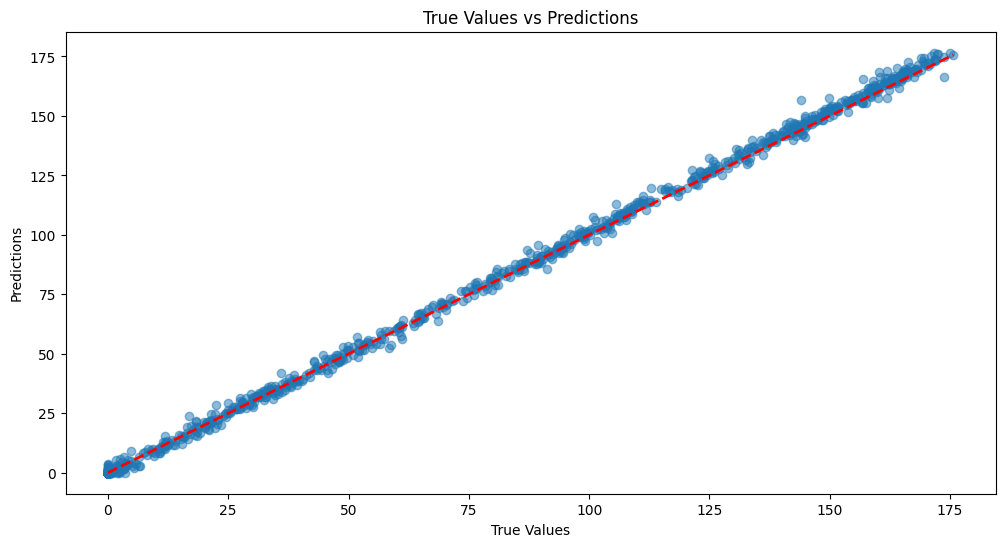

In [40]:
import matplotlib.pyplot as plt
from keras.optimizers import Adam

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Neural Network MAE: {mae}')
print(f'Neural Network MSE: {mse}')
print(f'Neural Network R^2 Score: {r2}')

# Plot true vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()


In [15]:
# Save only the model weights
model.save_weights('model__NN.weights.h5')


In [ ]:
response surface design